# Counting Rings in Cropped Images - Real Data


Mod of [Zach Muller's WWF 01_Custom.ipynb](https://walkwithfastai.com/Custom).

Here we'll take cropped images of antinodes and try to count the rings, by fashioning a *regression* model out of a one-class *classification* model and scaling the output sigmoid (via fastai's `y_range` parameter) so that our fitted values stay within the linear regime of the sigmoid. 

And we also want to "clamp" our output between a min of about 0.2 rings and a max of 11 rings, because that's how the dataset was created; so sigmoid makes a good choice for this "clamping" too.

In [ ]:
#hide
#all_slow

## Installs & Imports

In [ ]:
#hide
#Run once per session
!pip install fastai espiownage -q --upgrade

In [ ]:
import espiownage
from espiownage.core import *
sysinfo()
print(f"espiownage version {espiownage.__version__}")

TORCH_VERSION=torch1.9.0; CUDA_VERSION=cu102
CUDA available = True, Device count = 1, Current device = 0
Device name = NVIDIA GeForce RTX 2070 with Max-Q Design
hostname: oryxpro
espiownage version 0.0.45


And import our libraries

In [ ]:
from fastai.vision.all import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.data.external import untar_data, URLs

from fastai.data.block import RegressionBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize, ResizeMethod
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

import os

## Run parameters

In [ ]:
dataset_name = 'cleaner' # choose from: 
                            # - cleaner (*real* data that's clean-er than "preclean"), 
                            # - preclean (unedited aggregates of 15-or-more volunteers)
                            # - spnet,   (original SPNet Real dataset)
                            # - cyclegan (original SPNet CGSmall dataset)
                            # - fake (newer than SPNet fake, this includes non-int ring #s)
use_wandb = False        # WandB.ai logging
project = 'count_in_crops' # project name for wandb

In [ ]:
# Optional: WandB tracking
if use_wandb: 
    !pip install wandb -qqq
    import wandb
    from fastai.callback.wandb import *
    from fastai.callback.tracker import SaveModelCallback
    wandb.login()

## Prepare Dataset

In [ ]:
on_colab = os.path.exists('/content')

if on_colab:
    path = untar_data(f'http://hedges.belmont.edu/~shawley/espiownage-{dataset_name}.tgz') / 'crops'
else:
    path = Path(f'/home/shawley/datasets/espiownage-{dataset_name}/crops') 

print(path)

/home/shawley/datasets/espiownage-cleaner/crops


In [ ]:
fnames = get_image_files(path)  # image filenames
print(f"{len(fnames)} total cropped images")
ind = 1  # pick one cropped image
fnames[ind]

6614 total cropped images


Path('/home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00670_182_252_259_319_1.0.png')

For labels, we want the ring count which extract from the filename: It's the number between the last '_' and the '.png'

In [ ]:
def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

1.0


In [ ]:
# Define our datablock
cropsize = (300,300) # we will resize/reshape all input images to squares of this size
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                    get_items=get_image_files,
                    splitter=RandomSplitter(),  # Note the random splitting. K-fold is another notebook
                    get_y=label_func,
                    item_tfms=Resize(cropsize, ResizeMethod.Squish),
                    batch_tfms=[*aug_transforms(size=cropsize, flip_vert=True, max_rotate=360.0), 
                    Normalize.from_stats(*imagenet_stats)])
# define dataloaders
dls = croppedrings.dataloaders(path, bs=32)

/home/shawley/envs/espi/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


Take a look at sample target data.  Notice how they're very circular!  That's how we 'got away with' arbitrary (360 degree) rotations in the DataBlock's `batch_tfms`, above^. 

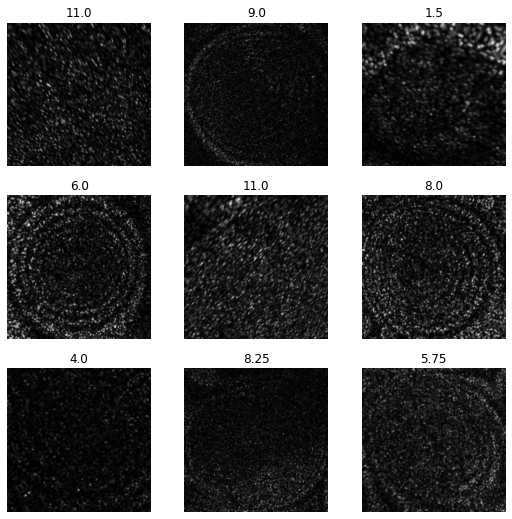

In [ ]:
dls.show_batch(max_n=9)

## Train model

In [ ]:
opt = ranger # optimizer the kids love these days

y_range=(0.2,13)  # balance between "clamping" to range of real data vs too much "compression" from sigmoid nonlinearity

if use_wandb:
    wandb.init(project=project, name=f'{dataset_name}')
    cbs = [WandbCallback()]
else:
    cbs = []

learn = cnn_learner(dls, resnet34, n_out=1, y_range=y_range, 
                    metrics=[mae, acc_reg05, acc_reg07, acc_reg1,acc_reg15,acc_reg2], 
                    loss_func=MSELossFlat(), opt_func=opt, cbs=cbs)

/home/shawley/envs/espi/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/home/shawley/envs/espi/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0063095735386013985)

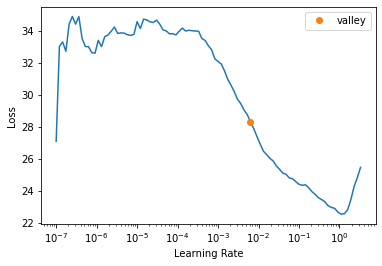

In [ ]:
# optional: learning rate finder
learn.lr_find() # we're just going to use 5e-3 though

In [ ]:
#learn.fine_tune(10, 1e-2)  # this also works quite well instead

lr = 5e-3
epochs = 30 # 10-11 epochs is fine for lr=1e-2; here we do 30 w/ lower lr to see if we can "do better"
learn.fine_tune(epochs, lr, freeze_epochs=2)  

epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg07,acc_reg1,acc_reg15,acc_reg2,time
0,12.132623,8.333554,2.139766,0.168684,0.260212,0.359304,0.467474,0.633132,00:37
1,8.537375,6.159438,1.778141,0.207262,0.318457,0.415280,0.534039,0.711800,00:37


epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg07,acc_reg1,acc_reg15,acc_reg2,time
0,5.634616,4.358781,1.419960,0.285174,0.391831,0.518154,0.646747,0.797277,00:49
1,4.187303,2.892364,1.119129,0.357035,0.470499,0.597579,0.759455,0.863843,00:49
2,3.487222,2.366174,0.996874,0.389561,0.527988,0.663389,0.812405,0.890318,00:49
3,2.886697,2.436984,1.021958,0.347958,0.478820,0.656581,0.809380,0.891831,00:50
4,2.304131,2.244427,0.929960,0.464448,0.571104,0.692133,0.828290,0.890318,00:50
5,2.277562,2.183543,0.863715,0.515129,0.636157,0.748109,0.847201,0.897126,00:50
6,2.173321,2.237372,0.972122,0.414523,0.535552,0.673979,0.794251,0.891831,00:50
7,2.138571,2.610636,1.004566,0.443268,0.574887,0.696672,0.798790,0.866868,00:50
8,2.132209,2.747030,0.983012,0.477307,0.583207,0.677005,0.819970,0.872163,00:50
9,1.955311,1.843903,0.810278,0.501513,0.605144,0.747352,0.863086,0.916793,00:50


^ we could go back up and cut this off at 10, 15 or 20 epochs. In this case I just wanted to explore how low the val_loss would go! 

In [ ]:
if use_wandb: wandb.finish()

In [ ]:
learn.save(f'crop-rings-{dataset_name}') # save a checkpoint so we can restart from here later

Path('models/crop-rings-cleaner.pth')

## Interpretation

In [ ]:
# load weights
learn.load(f'crop-rings-{dataset_name}'); # can start from here assuming learn, dls, etc are defined

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True) # validation set only
print(f"We have {len(preds)} predictions.")

We have 1322 predictions.


Let's define a method to show a single prediction

In [ ]:
def showpred(ind, preds, targs, losses, dls): # show prediction at this index
    print(f"preds[{ind}] = {preds[ind]}, targs[{ind}] = {targs[ind]}, loss = {losses[ind]}")
    print(f"file = {os.path.basename(dls.valid.items[ind])}")
    print("Image:")
    dls.valid.dataset[ind][0].show()

preds[0] = tensor([2.7427]), targs[0] = 2.5, loss = 0.058898016810417175
file = 06240907_proc_00658_210_0_289_91_2.5.png
Image:


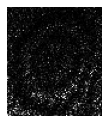

In [ ]:
showpred(0, preds, targs, losses, dls)

And now we'll run through predictions for the whole validation set:

In [ ]:
results = []
for i in range(len(preds)):
    line_list = [dls.valid.items[i].stem]+[round(targs[i].cpu().numpy().item(),2), round(preds[i][0].cpu().numpy().item(),2), losses[i].cpu().numpy(), i]
    results.append(line_list)

# store ring counts as as Pandas dataframe
res_df = pd.DataFrame(results, columns=['filename', 'target', 'prediction', 'loss','i'])

There is no fastai `top_losses` defined for this type, but we can do our own version of printing top_losses:

In [ ]:
res_df = res_df.sort_values('loss', ascending=False)
res_df.head()

,filename,target,prediction,loss,i
1123,06241902_proc_00522_0_34_91_246_1.0,1.0,11.33,106.80325,1123
1290,06241902_proc_01927_0_20_93_235_1.0,1.0,11.17,103.37906,1290
414,06241902_proc_00581_0_31_86_236_1.0,1.0,11.16,103.23883,414
1292,06241902_proc_00632_0_39_90_238_1.0,1.0,10.87,97.509445,1292
651,06241902_proc_00381_0_59_81_228_1.0,1.0,10.67,93.50479,651


preds[1123] = tensor([11.3346]), targs[1123] = 1.0, loss = 106.80325317382812
file = 06241902_proc_00522_0_34_91_246_1.0.png
Image:
preds[1290] = tensor([11.1675]), targs[1290] = 1.0, loss = 103.37905883789062
file = 06241902_proc_01927_0_20_93_235_1.0.png
Image:
preds[414] = tensor([11.1607]), targs[414] = 1.0, loss = 103.23883056640625
file = 06241902_proc_00581_0_31_86_236_1.0.png
Image:
preds[1292] = tensor([10.8747]), targs[1292] = 1.0, loss = 97.50944519042969
file = 06241902_proc_00632_0_39_90_238_1.0.png
Image:
preds[651] = tensor([10.6698]), targs[651] = 1.0, loss = 93.50479125976562
file = 06241902_proc_00381_0_59_81_228_1.0.png
Image:


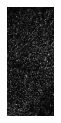

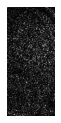

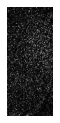

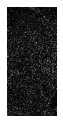

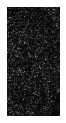

In [ ]:
def show_top_losses(res_df, preds, targs, losses, dls, n=5):
    for j in range(n):
        showpred(res_df.iloc[j]['i'], preds, targs, losses, dls)
        
show_top_losses(res_df, preds, targs, losses, dls)

So then we can these results output into a CSV file, and use it to direct our data-cleaning efforts, i.e. look at the top-loss images first! 

In [ ]:
res_df.to_csv(f'ring_count_top_losses_{dataset_name}.csv', index=False)

## Explore the Data
Let's take a look at plots of this data

In [ ]:
df2 = res_df.reset_index(drop=True)

Text(0, 0.5, 'Ring count')

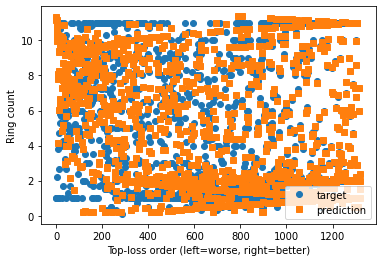

In [ ]:
plt.plot(df2["target"],'o',label='target')
plt.plot(df2["prediction"],'s', label='prediction')
plt.xlabel('Top-loss order (left=worse, right=better)')
plt.legend(loc='lower right')
plt.ylabel('Ring count')

(-0.44500000000000006, 11.853, -0.35900000000000004, 11.939)

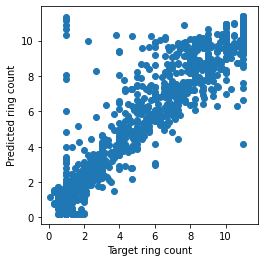

In [ ]:
plt.plot(df2["target"],df2["prediction"],'o')
plt.xlabel('Target ring count')
plt.ylabel('Predicted ring count')
plt.axis('square')

In [ ]:
print(f"Target ring count range: ({df2['target'].min()}, {df2['target'].max()})")
print(f"Predicted ring count range: ({df2['prediction'].min()}, {df2['prediction'].max()})")

Target ring count range: (0.1, 11.0)
Predicted ring count range: (0.2, 11.38)


# Plots for paper
wel'll re-do the above plots using the saved CSV file and similar files for the other datasets in order to make a composite plot. 